In [1]:
#Allows relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import deepcat_cnn
from src.torch_util import *
from src.dataloader import *
%load_ext autoreload
%autoreload 2
#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'
files = os.listdir(TRAINDIR)
files.remove('readme.md')
files

Using : cuda


['NormalCDR3.txt',
 'NormalCDR3_test.txt',
 'TumorCDR3.txt',
 'TumorCDR3_test.txt']

In [2]:
#Reading data
train_normal = read_seq(TRAINDIR+files[0])
train_tumor = read_seq(TRAINDIR+files[2])

test_normal = read_seq(TRAINDIR+files[1])
test_tumor = read_seq(TRAINDIR+files[3])
#For now, data has not been split into validation/train sets.
train_features, train_labels = generate_features_labels(train_tumor, train_normal, device)
test_features, test_labels = generate_features_labels(test_tumor, test_normal, device)

print("TRAIN TENSORS",train_features[12]['x'].shape, train_features[12]['x'].device)
print("LABELS", train_labels[12].shape, train_labels[12].device)

print("TEST TENSORS",test_features[15]['x'].shape, test_features[15]['x'].device)
print("LABELS", test_labels[15].shape, test_labels[15].device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cuda:0
LABELS torch.Size([7379]) cuda:0
TEST TENSORS torch.Size([7040, 1, 15, 15]) cuda:0
LABELS torch.Size([7040]) cuda:0


In [3]:
#Loading models 
model_dict = {}

for length in RANGE:
    model = deepcat_cnn(length)
    model.to(device)
    model_dict[length]=model
    del model

model_dict[15].length, model_dict[15].dummy_param.device

(15, device(type='cuda', index=0))

In [ ]:
"""  
def train(...):
     if torch.cuda.is_available():
       device = torch.device('cuda')
       print("Using : {}".format(device))
   else:
       device = torch.device('cpu')
       print("Using : {}".format(device))
       #    model = something
    model to device
    
    optimizer = optim.something(model.parameters, lr, ...)
    criterion = nn.CrossEntropyLoss
    etc.
    #Deal with data here
    
    for e in epochs:
        train_model(model, loss, optimizer, ...)
ex : 
def train(..)

    losses = {} a dictionary of lists of losses
    
    for epoch in nb_epochs:
        for length in range(12,17):
            data = feature_dict[length]
            labels = label_dict[length]
            model = model_dict[length]
            loss = train_model(...)
    
""" 

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import BatchSampler, RandomSampler    
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_data, target_labels,
                epoch, mini_batch_size):
    """
    Trains one version (length) of a given model
    Trains over mini-batches for one epoch.
    Another function should call do the task of getting each of the 5 models and datasets
    and call this function once for each pair.
    """
    model.train()
    train_loss = 0
    #Minibatch SGD, get a list of indices to separate the train data into batches 
    for b in list(BatchSampler(RandomSampler(range(train_data.size(0))),
                               batch_size=mini_batch_size, drop_last=False)):
        #Standard train loops
        output = model(train_data[b])
        loss = criterion(output, target_labels[b]) #criterion = nn.CEL
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    #train_loss /= train_data.size(0)
    #if e%200==0:
     #   print("Loss at epoch {e} : {l}".format(e=epoch,l=train_loss))
    return train_loss
#    
#
#def eval_model(model, criterion):
#    model.eval()

In [6]:
length = 12 
feats = train_features[length]['x'].detach().clone()
labels = train_labels[length].detach().clone()
model = model_dict[length]
optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print("feats",feats.shape, feats.device)
print("labs", labels.shape, labels.device)
print("model",model.dummy_param.device)

feats torch.Size([7379, 1, 15, 12]) cuda:0
labs torch.Size([7379]) cuda:0
model cuda:0


In [10]:
a= BatchSampler(RandomSampler(range(feats.size(0))), batch_size=100, drop_last=False)

In [12]:
b = list(a)

In [ ]:
import timeit

start = timeit.timeit()
print("hello")
end = timeit.timeit()
print(end - start)

In [18]:
from datetime import datetime

losses = []
optimizer = optim.SGD(model.parameters(), lr = 0.005)

for e in range(20000):
    loss = train_model(model, criterion, optimizer, feats, labels, e, 500)
    losses.append(loss)
    if e%200==0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("Loss at {e} epochs: {l}".format(e=e, l=loss))

Current Time = 14:27:24
Loss at 0 epochs: 20.573338866233826
Current Time = 14:27:47
Loss at 200 epochs: 20.604674696922302
Current Time = 14:28:10
Loss at 400 epochs: 20.067731022834778
Current Time = 14:28:33
Loss at 600 epochs: 20.340508818626404
Current Time = 14:28:55
Loss at 800 epochs: 19.981285274028778
Current Time = 14:29:20
Loss at 1000 epochs: 20.267720013856888
Current Time = 14:29:47
Loss at 1200 epochs: 19.99930790066719
Current Time = 14:30:13
Loss at 1400 epochs: 19.792585283517838
Current Time = 14:30:37
Loss at 1600 epochs: 19.784479469060898
Current Time = 14:31:01
Loss at 1800 epochs: 19.388214498758316
Current Time = 14:31:23
Loss at 2000 epochs: 19.396026849746704
Current Time = 14:31:46
Loss at 2200 epochs: 19.569690823554993
Current Time = 14:32:11
Loss at 2400 epochs: 19.3354389667511
Current Time = 14:32:35
Loss at 2600 epochs: 19.451843827962875
Current Time = 14:32:59
Loss at 2800 epochs: 19.229603230953217
Current Time = 14:33:21
Loss at 3000 epochs: 19.39

In [ ]:
#Took about 40 minutes for 20'000 epochs

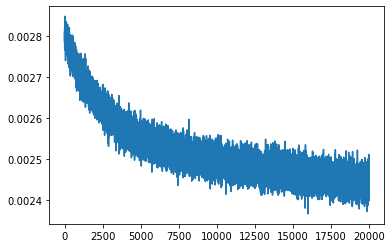

In [24]:
import matplotlib.pyplot as plt
xd = [x/labels.size(0) for x in losses]
#plt.plot(losses/labels.size(0))
plt.plot(xd)

In [9]:
model()

deepcat_cnn(
  (conv1): Conv2d(1, 8, kernel_size=(15, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(1, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [22]:
?accuracy_score

Signature: accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
Docstring:
Accuracy classification score.

In multilabel classification, this function computes subset accuracy:
the set of labels predicted for a sample must *exactly* match the
corresponding set of labels in y_true.

Read more in the :ref:`User Guide <accuracy_score>`.

Parameters
----------
y_true : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) labels.

y_pred : 1d array-like, or label indicator array / sparse matrix
    Predicted labels, as returned by a classifier.

normalize : bool, optional (default=True)
    If ``False``, return the number of correctly classified samples.
    Otherwise, return the fraction of correctly classified samples.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
score : float
    If ``normalize == True``, return the fraction of correctly
    classified samples (float), else returns the 

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
?roc_auc_score

Signature:
roc_auc_score(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
)
Docstring:
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from prediction scores.

Note: this implementation can be used with binary, multiclass and
multilabel classification, but some restrictions apply (see Parameters).

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
    True labels or binary label indicators. The binary and multiclass cases
    expect labels with shape (n_samples,) while the multilabel case expects
    binary label indicators with shape (n_samples, n_classes).

y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
    Target scores. In the binary and multilabel cases, these can be either
    probability estimates or non-thresholded decision values (as returned
    by `dec

In [24]:
logits = model(feats)

In [27]:
logits

tensor([[1.0712, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.3908, 0.0000],
        [1.3636, 0.0000],
        [0.0000, 0.0000]], device='cuda:0', grad_fn=<FusedDropoutBackward>)

In [29]:
from datetime import datetime

losses = []
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum=0.9, weight_decay = 1e-5)

for e in range(2000):
    loss = train_model(model, criterion, optimizer, feats, labels, e, 100)
    losses.append(loss)
    if e%200==0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("Loss at {e} epochs: {l}".format(e=e, l=loss))

Current Time = 17:00:10
Loss at 0 epochs: 42.46771255135536
Current Time = 17:00:44
Loss at 200 epochs: 37.59503474831581
Current Time = 17:01:18
Loss at 400 epochs: 36.91499978303909
Current Time = 17:01:52
Loss at 600 epochs: 36.53209784626961
Current Time = 17:02:28
Loss at 800 epochs: 35.669489324092865
Current Time = 17:03:03
Loss at 1000 epochs: 35.08933112025261
Current Time = 17:03:37
Loss at 1200 epochs: 34.3982315659523
Current Time = 17:04:12
Loss at 1400 epochs: 34.12680885195732
Current Time = 17:04:47
Loss at 1600 epochs: 34.29938131570816
Current Time = 17:05:21
Loss at 1800 epochs: 34.476052552461624


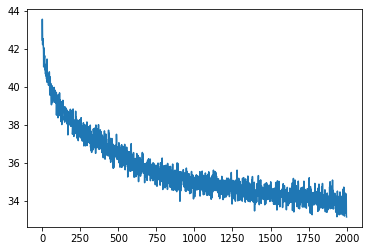

In [30]:
plt.plot(losses)

In [35]:
logits = model(feats)

In [103]:
def eval_model(model, criterion, data, labels, mini_batch_size):
    """
    Takes a model & evaluates it (AUC & Accuracy)
    """
    model.eval()
    one_hot = one_hot_labels(labels).cpu() # from preprocessing.py
    
    #Full test_set in case of unbalanced data
    #Logits = raw for loss, predictions = argmax(logit), probs = softmax(logit)
    logits = model(data) 
    predictions = logits.argmax(1)
    probs = logits.softmax(1)
    
    eval_loss = criterion(logits, labels) #criterion = nn.CEL
    accs = accuracy_score(labels.cpu(), predictions.cpu())
    AUCs = roc_auc_score(one_hot, probs.detach().cpu())

    return eval_loss, accs, AUCs


In [104]:
test_data = test_features[12]['x']
test_targets = test_labels[12]
len(test_data), len(test_targets)

(3182, 3182)

In [105]:
eval_model(model,criterion,test_data, test_targets,1000)

(tensor(0.4200, device='cuda:0', grad_fn=<NllLossBackward>),
 0.8315524827152734,
 0.9257044548278869)